In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle
import string
import numpy as np
import random
from collections import Counter

import glob

In [2]:
import nltk
#nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
#nltk.download('cmudict')

nltk.help.upenn_tagset()


[nltk_data] Downloading package tagsets to /home/joseph/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
   

In [3]:
#import nltk
#nltk.download('punkt')

In [4]:
from nltk.tokenize import sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
import nltk.data
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

from nltk.tag.stanford import StanfordPOSTagger

translator = str.maketrans('', '', string.punctuation + '”“')
punctuation_set = set(string.punctuation + '”“')


arpabet = nltk.corpus.cmudict.dict()
import textstat as ts
from textstat.textstat import textstat


/home/joseph/anaconda3/envs/insight/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/joseph/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Can skip ahead if you're just dealing with nyt, breit, wapo test data

In [5]:
try:
    total_df = pd.read_pickle('total_df.p')
except:
    df_1 = pd.read_csv('articles1.csv')
    df_2 = pd.read_csv('articles2.csv')
    df_3 = pd.read_csv('articles3.csv')
    #print(df_1.head(1))
    print(df_1.shape)

    #print(df_1.publication.unique())
    #print(df_2.publication.unique())
    #print(df_3.publication.unique())
    #merge dataframes
    total_df = pd.concat([df_1, df_2, df_3])
    df_1 = 0
    df_2 = 0
    df_3 = 0
    total_df['sentence_count'] = 0
    total_df['word_count'] = 0
    total_df.to_pickle('total_df.p')
publication_names = total_df.publication.unique()

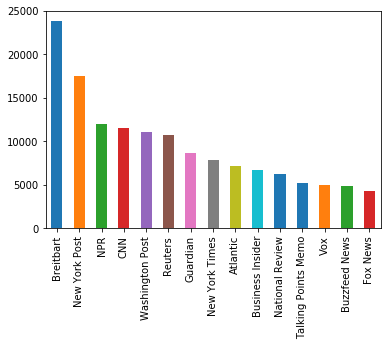

In [6]:
total_df.publication.value_counts().plot(kind='bar')

In [ ]:
print(list(total_df))
#print(total_df.loc[total_df['publication'] == 'New York Times']['title'])

In [ ]:
#nyt_list = total_df.loc[total_df['publication'] == 'New York Times']['content'].tolist()
total_df = total_df.loc[total_df['publication'] == 'Fox News']
#nyt_semic = nyt_df[nyt_df['content'].str.contains(";")]
#breit_list = total_df.loc[total_df['publication'] == 'Breitbart']['content'].tolist()
#wapo_list = total_df.loc[total_df['publication'] == 'Washington Post']['content'].tolist()

In [ ]:
print(nyt_semic.shape)

In [ ]:
def rand_list(num_articles):
    return [random.random() for _ in range(num_articles)]

In [ ]:
def get_id_content_list(pubname, num_articles):
    min_length_cutoff = 50
    df_cont_list = total_df.loc[total_df['publication'] == pubname]['content'].tolist()
    df_id_list = total_df.loc[total_df['publication'] == pubname]['id'].tolist()
    df_auth_list = total_df.loc[total_df['publication'] == pubname]['author'].tolist()
    df_id_list = [i for ci, i in enumerate(df_id_list) if len(df_cont_list[ci]) > min_length_cutoff]
    df_auth_list = [i for ci, i in enumerate(df_auth_list) if len(df_cont_list[ci]) > min_length_cutoff]
    df_cont_list = [i for i in df_cont_list if len(i) > min_length_cutoff]
    num_articles_in_set = len(df_id_list)
    num_rand_to_get = num_articles_in_set if num_articles > num_articles_in_set else num_articles
    if num_articles > num_articles_in_set:
        print('Warning!', pubname, 'only has ', str(len(df_id_list)), ' articles, but you are asking for ', str(num_articles))
        #num_articles = num_articles_in_set
    random_num_list = rand_list(num_articles_in_set)
    cont_list =   [i for ci,i in enumerate(df_cont_list)   if random_num_list[ci] > 1-num_rand_to_get/num_articles_in_set]
    id_list =     [i for ci,i in enumerate(df_id_list)     if random_num_list[ci] > 1-num_rand_to_get/num_articles_in_set]
    auth_list =   [i for ci,i in enumerate(df_auth_list)   if random_num_list[ci] > 1-num_rand_to_get/num_articles_in_set]
    return cont_list, id_list, auth_list

In [7]:
def prepare_text(publication_content_list):
    if type(publication_content_list) is not list:
        publication_content_list = [publication_content_list]
    #lower case text
    lower_case = [text.strip().lower() for text in publication_content_list]
    #replace strange quote characters with normal ones 
    replace_quotes = [text.replace('“', '"').replace('”', '"') for text in lower_case]
    #do punkt sentence tokenization
    sentence_tokenize = [sent_detector.tokenize(text.strip()) for text in replace_quotes]
    #do nltk word tokenization
    word_tokenize = [nltk.word_tokenize(text) for text in replace_quotes]
    #get unique string counts
    string_counts = [Counter(text) for text in word_tokenize]
    #pos_tagging
    pos_tag = [nltk.pos_tag(text) for text in word_tokenize]
    return sentence_tokenize, word_tokenize, string_counts, pos_tag

In [ ]:
num_articles = 5000

#print(len(nyt_list), len(breit_list), len(wapo_list))
#print(nyt_list[0][:200], nyt_id[0], guard_list[0][:200])

In [ ]:
nyt_list  , nyt_id  , nyt_auth   = get_id_content_list('New York Times', num_articles)
nyt_sent, nyt_word, nyt_string_count, nyt_pos = prepare_text(nyt_list)

In [ ]:
total_df = []
pickle.dump( ['nyt', nyt_id, nyt_auth, nyt_sent, nyt_word, 
              nyt_string_count, nyt_pos], open( "nyt_tokenized_strings.p", "wb" ) )

In [ ]:
print(nyt_pos[0][:50])

In [ ]:
breit_list, breit_id, breit_auth = get_id_content_list('Breitbart', num_articles)
breit_sent, breit_word, breit_string_count, breit_pos = prepare_text(breit_list)
pickle.dump( ['breit', breit_id, breit_auth, breit_sent, 
              breit_word, breit_string_count, breit_pos], open( "breit_tokenized_strings.p", "wb" ) )


In [ ]:
wapo_list , wapo_id , wapo_auth  = get_id_content_list('Washington Post', num_articles)
wapo_sent, wapo_word, wapo_string_count, wapo_pos = prepare_text(wapo_list)
pickle.dump( ['wapo', wapo_id, wapo_auth, wapo_sent, 
              wapo_word, wapo_string_count, wapo_pos], open( "wapo_tokenized_strings.p", "wb" ) )


In [ ]:
guard_list, guard_id, guard_auth = get_id_content_list('Guardian', num_articles)
guard_sent, guard_word, guard_string_count, guard_pos = prepare_text(guard_list)
pickle.dump( ['guard', guard_id, guard_auth, guard_sent, 
              guard_word, guard_string_count, guard_pos], open( "guard_tokenized_strings.p", "wb"))


In [ ]:
buzz_list, buzz_id, buzz_auth = get_id_content_list('Buzzfeed News', num_articles)
buzz_sent, buzz_word, buzz_string_count, buzz_pos = prepare_text(buzz_list)
pickle.dump( ['buzz', buzz_id, buzz_auth, buzz_sent, 
              buzz_word, buzz_string_count, buzz_pos], open( "buzz_tokenized_strings.p", "wb"))


In [ ]:
atl_list, atl_id, atl_auth = get_id_content_list('Atlantic', num_articles)
atl_sent, atl_word, atl_string_count, atl_pos = prepare_text(atl_list)
pickle.dump( ['atl', atl_id, atl_auth, atl_sent, 
              atl_word, atl_string_count, atl_pos], open( "atl_tokenized_strings.p", "wb"))


In [ ]:
vox_list, vox_id, vox_auth = get_id_content_list('Vox', num_articles)
vox_sent, vox_word, vox_string_count, vox_pos = prepare_text(vox_list)

In [ ]:
total_df = []
pickle.dump( ['vox', vox_id, vox_auth, vox_sent, 
              vox_word, vox_string_count, vox_pos], open( "vox_tokenized_strings.p", "wb"))

In [ ]:
natrev_list, natrev_id, natrev_auth = get_id_content_list('National Review', num_articles)
natrev_sent, natrev_word, natrev_string_count, natrev_pos = prepare_text(natrev_list)

In [ ]:
total_df = []
pickle.dump( ['natrev', natrev_id, natrev_auth, natrev_sent, 
              natrev_word, natrev_string_count, natrev_pos], open( "natrev_tokenized_strings.p", "wb"))

In [ ]:
fox_list, fox_id, fox_auth = get_id_content_list('Fox News', num_articles)
fox_sent, fox_word, fox_string_count, fox_pos = prepare_text(fox_list)

In [ ]:
pickle.dump( ['fox', fox_id, fox_auth, fox_sent, 
              fox_word, fox_string_count, fox_pos], open( "fox_tokenized_strings.p", "wb"))

In [ ]:
# ['breit', breit_sent, breit_word, breit_string_count],
# ['wapo', wapo_sent, wapo_word, wapo_string_count]]

# Can start here if you don't care about which articles you got, and you have the article pickle files

In [ ]:
#unpickle files
pub, nyt_id, nyt_auth, nyt_sent, nyt_word, nyt_string_count, nyt_pos = pickle.load( open( "nyt_tokenized_strings.p", "rb" ) )
pub, breit_id, breit_auth, breit_sent, breit_word, breit_string_count, breit_pos = pickle.load( open( "breit_tokenized_strings.p", "rb" ) )
pub, wapo_id, wapo_auth, wapo_sent, wapo_word, wapo_string_count, wapo_pos = pickle.load( open( "wapo_tokenized_strings.p", "rb" ) )
pub, guard_id, guard_auth, guard_sent, guard_word, guard_string_count, guard_pos = pickle.load( open( "guard_tokenized_strings.p", "rb" ) )

In [ ]:
stanford_pos = StanfordPOSTagger('postagger/models/english-bidirectional-distsim.tagger', 'postagger/stanford-postagger.jar')

In [7]:
print(textstat.flesch_reading_ease('hi, how are you?'))
#get pronunciation of words
#pro_words_1 = [(i, arpabet[i][0]) for i in sort_1 if i in arpabet]

118.18


In [12]:
class Publication():
    
    def __init__(self, pub_id = '', pub_sent = [], pub_word = [], pub_string_count = [], pub_pos = []):
        self.publication_name = pub_id
        #self.id_list = pub_id_list
        self.sent_tok = pub_sent
        self.word_tok = pub_word
        self.string_count = pub_string_count
        self.pos = pub_pos
    
    def calc_word_count(self):
        self.word_count_punc = [len(text) for text in self.word_tok]
        self.word_count = [len([word for word in text if word not in punctuation_set]) for text in self.word_tok]
        
    def calc_sent_count(self):
        self.sent_count = [len(text) for text in self.sent_tok]
        
    def calc_sent_len(self):
        if not self.word_count:
            self.calc_word_count()
        if not self.sent_count:
            self.calc_sent_count
        self.sent_len = [float(i/j) for i,j in zip(self.word_count, self.sent_count)]
        
    def calc_unique_words(self):
        self.unique_wc = [len(set([word for word in text if word not in punctuation_set])) for text in self.word_tok]
        self.unique_word_frac = [float(i/j) for i,j in zip(self.unique_wc, self.word_count)]

    def calc_word_length(self):
        self.word_len = [np.mean([len(word) for word in text if word not in punctuation_set]) for text in self.word_tok]

    def calc_sent_len_std(self):
        self.sent_len_std = [np.std([len(sent) for sent in text]) for text in self.sent_tok]
        
    def calc_punc_ps(self):
        if not self.sent_count:
            self.calc_sent_count()
        self.cps = [float(counter[',']/sent_num) for counter, sent_num in zip(self.string_count, self.sent_count)]
        self.qps = [float(counter['?']/sent_num) for counter, sent_num in zip(self.string_count, self.sent_count)]
        self.exps = [float(counter['!']/sent_num) for counter, sent_num in zip(self.string_count, self.sent_count)]
        self.said_ps = [float(counter['said']/sent_num) for counter, sent_num in zip(self.string_count, self.sent_count)]
        self.but_ps = [float(counter['but']/sent_num) for counter, sent_num in zip(self.string_count, self.sent_count)]
        self.and_ps = [float(counter['and']/sent_num) for counter, sent_num in zip(self.string_count, self.sent_count)]

    def calc_pos_counts(self):
        #tag text:
        self.adverb_count = []
        self.verb_count = []
        self.adj_count = []
        self.FW_count = []
        for ci, article in enumerate(self.pos):
            if not ci%1000:
                print(ci)
            article_adverb_dict = {'RB': 0, 'RBR': 0, 'RBS': 0, 'WRB': 0}
            article_verb_dict = {'VB': 0, 'VBD': 0, 'VBG': 0, 'VBN': 0 , 'VBZ': 0, 'VBP': 0}
            article_adj_dict = {'JJ': 0, 'JJR': 0, 'JJS': 0}
            article_FW = 0
            for article in self.pos:
                for word in article:
                    if 'RB' in word[1]:
                        #print(word[0], word[1])
                        #RB: adverb
                        #    occasionally unabatingly maddeningly adventurously professedly
                        #    stirringly prominently technologically magisterially predominately
                        #    swiftly fiscally pitilessly ...
                        #RBR: adverb, comparative
                        #    further gloomier grander graver greater grimmer harder harsher
                        #    healthier heavier higher however larger later leaner lengthier less-
                        #    perfectly lesser lonelier longer louder lower more ...
                        #RBS: adverb, superlative
                        #    best biggest bluntest earliest farthest first furthest hardest
                        #    heartiest highest largest least
                        #WRB: what, where, who, when
                        article_adverb_dict[word[1]] += 1
                        #article_adv_count += 1
                    if 'VB' in word[1]:
                        #VB: verb, base form
                        #ask assemble assess assign assume atone attention avoid bake balkanize
                        #    bank begin behold believe bend benefit bevel beware bless boil bomb
                        #    boost brace break bring broil brush build ...
                        #VBD: verb, past tense
                        #    dipped pleaded swiped regummed soaked tidied convened halted registered
                        #    cushioned exacted snubbed strode aimed adopted belied figgered
                        #    speculated wore appreciated contemplated ...
                        #VBG: verb, present participle or gerund
                        #    telegraphing stirring focusing angering judging stalling lactating
                        #    hankerin' alleging veering capping approaching traveling besieging
                        #    encrypting interrupting erasing wincing ...
                        #VBN: verb, past participle
                        #    multihulled dilapidated aerosolized chaired languished panelized used
                        #    experimented flourished imitated reunifed factored condensed sheared
                        #    unsettled primed dubbed desired ...
                        #VBP: verb, present tense, not 3rd person singular
                        #    predominate wrap resort sue twist spill cure lengthen brush terminate
                        #    appear tend stray glisten obtain comprise detest tease attract
                        #    emphasize mold postpone sever return wag ...
                        #VBZ: verb, present tense, 3rd person singular
                        #    bases reconstructs marks mixes displeases seals carps weaves snatches
                        #    slumps stretches authorizes smolders pictures emerges stockpiles
                        #    seduces fizzes uses bolsters slaps speaks pleads
                        article_verb_dict[word[1]] += 1
                        #article_verb_count += 1
                    if 'JJ' in word[1]:
                        #JJ: adjective or numeral, ordinal
                            #third ill-mannered pre-war regrettable oiled calamitous first separable
                            #ectoplasmic battery-powered participatory fourth still-to-be-named
                            #multilingual multi-disciplinary ...
                        #JJR: adjective, comparative
                            #bleaker braver breezier briefer brighter brisker broader bumper busier
                            #calmer cheaper choosier cleaner clearer closer colder commoner costlier
                            #cozier creamier crunchier cuter ...
                        #JJS: adjective, superlative
                            #calmest cheapest choicest classiest cleanest clearest closest commonest
                            #corniest costliest crassest creepiest crudest cutest darkest deadliest
                            #dearest deepest densest dinkiest ...
                        article_adj_dict[word[1]] += 1
                    if 'FW' == word[1]:
                        #foreign word
                        article_FW += 1
            self.adverb_count.append(article_adverb_dict)
            self.verb_count.append(article_verb_dict)
            self.adj_count.append(article_adj_dict)
            self.FW_count.append(article_FW)
        #input()
        #verb count:
        
        #noun count:
            
    def calc_sentiment_polarity(self):
        self.sentiment_vec = []
        for ci, article in enumerate(self.sent_tok):
            if not ci%1000:
                print(ci)
            sentence_count = len(article)
            #compound, positive, neutral, negative
            document_score = [0,0,0,0]
            for sentence in article:
                #print(sentence)
                ss = sid.polarity_scores(sentence)
                document_score[0] += ss['compound']
                document_score[1] += ss['pos']
                document_score[2] += ss['neu']
                document_score[3] += ss['neg']
                #print(ss)
                #for k in sorted(ss):
                #    print('{0}: {1}, '.format(k, ss[k]), end='')
                #    print()
                #input()
            document_score = [float(i/sentence_count) for i in document_score]
            self.sentiment_vec.append(document_score)
            
    def calc_flesch_level(self):
        #206.835 - (total words/total sentences) * 1.015 - (total syllables / total words) * 84.6
        #print(sum([len(word)/3. if word not in arpabet else len(arpabet[word][0]) for word in self.word_tok[0] if word not in punctuation_set]))
        #print(self.sent_len[0], self.word_count[0])
        #input()
        #self.flesch_level = [sl * 0.39 + 11.8 * np.mean(
        #    [len(word)/3. if word not in arpabet else len(arpabet[word][0]) 
        #     for word in text if word not in punctuation_set]) - 15.59
        #                     for text, sl, wc in zip(self.word_tok, self.sent_len, self.word_count)]
        self.flesch_level = [textstat.flesch_reading_ease(' '.join(text)) for text in self.sent_tok]
        
#feature names: word_count, sent_count, sent_len, unique_word_frac, word_len, sent_len_std, cps
    

# load, process, and save to dataframe:

In [13]:
import glob
f_list = glob.glob('*_tokenized_strings.p')

for file in f_list:
    pub_abbrev = file[:-20]
    print(pub_abbrev)
    pub, article_id, auth, sent, word, string_count, pos = pickle.load(open(file, 'rb'))
    
    inst = Publication(pub, sent, word, string_count, pos)
    inst.calc_word_count()
    inst.calc_sent_count()
    inst.calc_sent_len()
    inst.calc_unique_words()
    inst.calc_word_length()
    inst.calc_sent_len_std()
    #nyt.calc_punc_ps()
    #inst.calc_flesch_level()
    inst.calc_pos_counts()
    inst.calc_punc_ps()
    print(inst.pos_counts[0][:10])
    break
#pub, nyt_id, nyt_auth, nyt_sent, nyt_word, nyt_string_count, nyt_pos = pickle.load( open( "nyt_tokenized_strings.p", "rb" ) )

#
#nyt = Publication("New York Times", nyt_id, nyt_sent, nyt_word, nyt_string_count, pos)


#nyt.calc_word_count()
#nyt.calc_sent_count()
#nyt.calc_sent_len()
#nyt.calc_unique_words()
#nyt.calc_word_length()
#nyt.calc_sent_len_std()
#nyt.calc_punc_ps()
#nyt.calc_flesch_level()
#nyt.calc_pos_counts()
#nyt.calc_punc_ps()
#print(nyt.flesch_level)



guard
0


KeyError: ('second', 'JJ')

# New York Times

In [ ]:
nyt = Publication("New York Times", nyt_id, nyt_sent, nyt_word, nyt_string_count)
#nyt.calc_word_count()
nyt.calc_sent_count()
#nyt.calc_sent_len()
#nyt.calc_unique_words()
#nyt.calc_word_length()
#nyt.calc_sent_len_std()
#nyt.calc_punc_ps()
#nyt.calc_flesch_level()
#nyt.calc_pos_counts()
nyt.calc_punc_ps()
#print(nyt.flesch_level)



#nyt.calc_pos_counts()
#print(nyt.adverb_count)
#nyt.calc_sentiment_polarity()
breit = Publication("Breitbart", breit_id, breit_sent, breit_word, breit_string_count)
#breit.calc_word_count()
breit.calc_sent_count()
#breit.calc_sent_len()
#breit.calc_unique_words()
#breit.calc_word_length()
#breit.calc_sent_len_std()
breit.calc_punc_ps()
#breit.calc_flesch_level()
#breit.calc_pos_counts()
#breit.calc_sentiment_polarity()

#pickle.dump( [nyt], open( "nyt_instance.p", "wb" ) )


wapo = Publication("Washington Post", wapo_id, wapo_sent, wapo_word, wapo_string_count)
#wapo.calc_word_count()
wapo.calc_sent_count()
#wapo.calc_sent_len()
#wapo.calc_unique_words()
#wapo.calc_word_length()
#wapo.calc_sent_len_std()
wapo.calc_punc_ps()
#wapo.calc_flesch_level()
#wapo.calc_pos_counts()
#wapo.calc_sentiment_polarity()

guard = Publication("Guardian", guard_id, guard_sent, guard_word, guard_string_count)
#guard.calc_word_count()
guard.calc_sent_count()
#guard.calc_sent_len()
#guard.calc_unique_words()
#guard.calc_word_length()
#guard.calc_sent_len_std()
guard.calc_punc_ps()
#guard.calc_flesch_level()
#guard.calc_pos_counts()
#guard.calc_sentiment_polarity()

In [ ]:
#adverb_count
#wapo.calc_sent_count()
#nyt.calc_sent_count()
#breit.calc_sent_count()
for i in [nyt, breit, wapo, guard]:
    #print(breit.adverb_count)
    #VB, VBD, VBG, VBN, VBP, VBZ
    #JJ, JJS, JJR
    #RB, RBS, RBR, WRB
    plt.hist([k/j for k,j in zip(i.FW_count, i.sent_count)], bins = [i/1000. for i in list(range(0,500,10))], normed = True, alpha = 0.7)
plt.legend(labels = pub_list_labels)
plt.title("Adverbs per sentence")
plt.show()

In [ ]:
#sentiment score
for i in [nyt, breit, wapo]:
    #print(breit.adverb_count)
    #plt.hist([component[1]+component[3] for component in i.sentiment_vec], bins = [i/100. for i in list(range(0,200,1))], normed = True, alpha = 0.5)
    plt.scatter([component[1] for component in i.sentiment_vec], [component[3] for component in i.sentiment_vec], s = 1, alpha = 0.8)
plt.legend(labels = pub_list_labels)
plt.title("Sentiment score metrics (vader)")
plt.show()

# Finished features go into the plotting box below, in progress ones go above

In [ ]:
pub_list = [nyt, breit, wapo, guard]
pub_list_labels = ['NYT', 'Breitbart', 'Washington Post', 'Guardian']

# Plot Data

In [ ]:
# Word Count

for i in [nyt, breit, wapo, guard]:
    plt.hist(i.word_count, bins = list(range(0,3000,50)), normed = True, alpha = 0.7)
plt.legend(labels = pub_list_labels)
plt.title("Word count")
plt.show()

# Sentence Count

for i in [nyt, breit, wapo, guard]:
    plt.hist(i.sent_count, bins = list(range(0,250,5)), normed = True, alpha = 0.7)
plt.legend(labels = pub_list_labels)
plt.title("Sentence count")
plt.show()
# Sentence Length

for i in [nyt, breit, wapo, guard]:
    plt.hist(i.sent_len, bins = list(range(0,50,1)), normed = True, alpha = 0.7)
plt.legend(labels = pub_list_labels)
plt.title("Sentence length")
plt.show()
# Unique Word Count and Fraction

for i in [nyt, breit, wapo, guard]:
    plt.hist(i.unique_word_frac, bins = [i/100. for i in list(range(0,100,1))], normed = True, alpha = 0.7)
plt.legend(labels = pub_list_labels)
plt.title("Unique word fraction")
plt.show()

# Mean word length

for i in [nyt, breit, wapo, guard]:
    print(i.word_len[:10])
    plt.hist([j for j in i.word_len if not np.isnan(j)], bins = [i/100. for i in list(range(300,650,5))], normed = True, alpha = 0.7)
plt.legend(labels = pub_list_labels)
plt.title("Mean word length")
plt.show()

# Sentence length distribution

for i in [nyt, breit, wapo, guard]:
    plt.hist(i.sent_len_std, bins = list(range(0,170,2)), normed = True, alpha = 0.7)
plt.legend(labels = pub_list_labels)
plt.title("Sentence length variability")
plt.show()

# Commas per sentence

for i in [nyt, breit, wapo, guard]:
    plt.hist(i.cps, bins = [i/100. for i in list(range(0,300,5))], normed = True, alpha = 0.7)
plt.legend(labels = pub_list_labels)
plt.title("Commas per sentence")
plt.show()


for i in [nyt, breit, wapo, guard]:
    plt.hist(i.qps, bins = [i/1000. for i in list(range(0,200,5))], normed = True, alpha = 0.7)
plt.legend(labels = pub_list_labels)
plt.title("Question marks per sentence")
plt.show()


for i in [nyt, breit, wapo, guard]:
    plt.hist(i.exps, bins = [i/1000. for i in list(range(0,100,5))], normed = True, alpha = 0.7)
plt.legend(labels = pub_list_labels)
plt.title("Exclamation marks per sentence")
plt.show()


for i in [nyt, breit, wapo, guard]:
    plt.hist(i.flesch_level, bins = [i/1. for i in list(range(0,100,5))], normed = True, alpha = 0.7)
plt.legend(labels = pub_list_labels)
plt.title("Flesch readability")
plt.show()

In [ ]:
#join data
wc = []
sent_len = []
sent_len_std = []
unique_word_frac = []
word_len = []
cps = []
qps = []
exps = []
adverb_ps = []
sup_adv_ps = []
verb_ps = []
sent_compound = []
flesch = []
#n_articles = 2000
#VB, VBD, VBG, VBN, VBP, VBZ
#RB, WRB, RBR, RBS
#JJ, JJR, JJS
#feature names: word_count, sent_count, sent_len, unique_word_frac, word_len, sent_len_std, cps
for i in [nyt_feature_df, breit_feature_df, wapo_feature_df, guard_feature_df]:
    wc += i.word_count.tolist()
    sent_len += i.sent_len.tolist()
    word_len += i.word_len.tolist()
    sent_len_std += i.sent_len_std.tolist()
    unique_word_frac += i.unique_word_frac.tolist()
    cps += i.cps.tolist()
    qps += i.qps.tolist()
    exps += i.exps.tolist()
    flesch += i.flesch.tolist()
    #adverb_ps += [float(sum(dict_vals.values())/sl) for dict_vals, sl in zip(i.adverb_count, i.sent_count)]
    #sup_adv_ps += [float(dict_vals['WRB']/sl) for dict_vals, sl in zip(i.adverb_count, i.sent_count)]
    #verb_ps += [float(dict_vals['VBZ']/sl) for dict_vals, sl in zip(i.verb_count, i.sent_count)]
    #sent_compound += [vec[2] if vec[1] + vec[3] == 0 else vec[2]/(vec[1] + vec[3]) for vec in i.sentiment_vec]
#print(sup_adv_ps[:10])
#print(sent_compound[:10])
print(flesch[:10])
#print(nyt.adverb_count)
#print(total_adverb_ps[:10])
#wc = nyt_wc + breit_wc + wapo_wc
#sent_len = nyt_sent_len + breit_sent_len + wapo_sent_len
#sent_len_std = nyt_sent_len_std + breit_sent_len_std + wapo_sent_len_std
#unique_word_frac = nyt_unique_word_frac + breit_unique_word_frac + wapo_unique_word_frac
#word_len = nyt_word_len + breit_word_len + wapo_word_len
#cps = nyt_cps + breit_cps + wapo_cps
#print(len(wc), len(word_length))

# Measure correlations 

In [ ]:
#put features into a pandas df
breit_feature_df = pd.DataFrame(
    {'word_count': breit.word_count,
     'sent_len': breit.sent_len,
     'word_len': breit.word_len,
     'sent_len_std': breit.sent_len_std,
     'unique_word_frac': breit.unique_word_frac,
     'cps': breit.cps,
     'qps': breit.qps,
     'exps': breit.exps,
     'adverbs': breit.adverb_count,
     'verbs': breit.verb_count,
     'adjectives' : breit.adj_count,
     'foreign' : breit.FW_count,
     'flesch': breit.flesch_level
     #'sent_compound': [vec[0] for vec in breit.sentiment_vec]
    })


nyt_feature_df = pd.DataFrame(
    {'word_count': nyt.word_count,
     'sent_len': nyt.sent_len,
     'word_len': nyt.word_len,
     'sent_len_std': nyt.sent_len_std,
     'unique_word_frac': nyt.unique_word_frac,
     'cps': nyt.cps,
     'qps': nyt.qps,
     'exps': nyt.exps,
     'adverbs': nyt.adverb_count,
     'verbs': nyt.verb_count,
     'adjectives' : nyt.adj_count,
     'foreign' : nyt.FW_count,
     'flesch': nyt.flesch_level
     #'sent_compound': [vec[0] for vec in breit.sentiment_vec]
    })


wapo_feature_df = pd.DataFrame(
    {'word_count': wapo.word_count,
     'sent_len': wapo.sent_len,
     'word_len': wapo.word_len,
     'sent_len_std': wapo.sent_len_std,
     'unique_word_frac': wapo.unique_word_frac,
     'cps': wapo.cps,
     'qps': wapo.qps,
     'exps': wapo.exps,
     'adverbs': wapo.adverb_count,
     'verbs': wapo.verb_count,
     'adjectives' : wapo.adj_count,
     'foreign' : wapo.FW_count,
     'flesch': wapo.flesch_level
     #'sent_compound': [vec[0] for vec in breit.sentiment_vec]
    })

guard_feature_df = pd.DataFrame(
    {'word_count': guard.word_count,
     'sent_len': guard.sent_len,
     'word_len': guard.word_len,
     'sent_len_std': guard.sent_len_std,
     'unique_word_frac': guard.unique_word_frac,
     'cps': guard.cps,
     'qps': guard.qps,
     'exps': guard.exps,
     'adverbs': guard.adverb_count,
     'verbs': guard.verb_count,
     'adjectives' : guard.adj_count,
     'foreign' : guard.FW_count,
     'flesch': guard.flesch_level
     #'sent_compound': [vec[0] for vec in breit.sentiment_vec]
    })

# Add new feature from class instances

In [ ]:
df_list = [nyt_feature_df, breit_feature_df, wapo_feature_df, guard_feature_df]
for df_id, inst_id in zip(df_list, [nyt, breit, wapo, guard]):
    df_id['but_ps'] = inst_id.but_ps
    df_id['and_ps'] = inst_id.and_ps

In [ ]:
pickle.dump(['nyt', nyt_feature_df, 'breit', breit_feature_df,
             'wapo', wapo_feature_df, 'guard', guard_feature_df], open( "nyt_data_df.p", "wb" ) )

# Unpickle saved feature frame

In [ ]:
[pub_nyt, nyt_feature_df, pub_breit, breit_feature_df,
             pub_wapo, wapo_feature_df, pub_guard, guard_feature_df] =  pickle.load(open( "nyt_data_df.p", "rb" ))

In [ ]:
print(list(nyt_feature_df))

In [ ]:
df_list = [nyt_feature_df, breit_feature_df, wapo_feature_df, guard_feature_df]
for i in df_list:
    i.rename(columns={'adverb_ps': 'adverbs'}, inplace=True)

In [ ]:
samples_per_df = []
for ci,i in enumerate(df_list):
    i['label'] = ci
    #totals
    i['total_adv'] = i['adverbs'].apply(lambda row: sum(row.values()))
    i['total_verb'] = i['verbs'].apply(lambda row: sum(row.values()))
    i['total_adj'] = i['adjectives'].apply(lambda row: sum(row.values()))
    #sentence_count
    i['sent_count'] = i['word_count']/i['sent_len']
    
    #per_sentence
    i['adv_ps'] = i['total_adv']/(i['sent_count'])
    i['verb_ps'] = i['total_verb']/(i['sent_count'])
    i['adj_ps'] = i['total_adj']/(i['sent_count'])
    ##################
    #VB, VBD, VBG, VBN, VBP, VBZ
    #JJ, JJS, JJR
    #RB, RBS, RBR, WRB
    #################
    #adverb_subtypes
    i['RB_ps'] = i['adverbs'].apply(lambda row: row['RB'])/i['sent_count']
    i['RBR_ps'] = i['adverbs'].apply(lambda row: row['RBR'])/i['sent_count']
    i['RBS_ps'] = i['adverbs'].apply(lambda row: row['RBS'])/i['sent_count']
    i['WRB_ps'] = i['adverbs'].apply(lambda row: row['WRB'])/i['sent_count']
    
    #verb_subtypes
    i['VB_ps'] = i['verbs'].apply(lambda row: row['VB'])/i['sent_count']
    i['VBD_ps'] = i['verbs'].apply(lambda row: row['VBD'])/i['sent_count']
    i['VBG_ps'] = i['verbs'].apply(lambda row: row['VBG'])/i['sent_count']
    i['VBN_ps'] = i['verbs'].apply(lambda row: row['VBN'])/i['sent_count']
    i['VBP_ps'] = i['verbs'].apply(lambda row: row['VBP'])/i['sent_count']
    i['VBZ_ps'] = i['verbs'].apply(lambda row: row['VBZ'])/i['sent_count']
    
    #adj_subtypes
    i['JJ_ps'] = i['adjectives'].apply(lambda row: row['JJ'])/i['sent_count']
    i['JJS_ps'] = i['adjectives'].apply(lambda row: row['JJS'])/i['sent_count']
    i['JJR_ps'] = i['adjectives'].apply(lambda row: row['JJR'])/i['sent_count']


    samples_per_df.append(len(i))
print(nyt_feature_df.head(10))
print(list(nyt_feature_df))
print(samples_per_df)

In [36]:
f_list = glob.glob('*_data_df.p')
df_list = []
for fname in f_list:
    if 'jupyter' not in fname:
        df_list.append(pickle.load(open( fname, 'rb' )))
#print(df_list[5])

In [37]:
full_feature_df= pd.concat(df_list)

### from sklearn import tree
#X = [[0, 0], [1, 1]]
#Y = [0, 1]
#clf = tree.DecisionTreeClassifier()
#clf = clf.fit(X, Y)

   word_count   sent_len  word_len  sent_len_std  unique_word_frac       cps  \
0         903  34.730769  5.125138     70.186438          0.434109  1.807692   
1        2197  30.095890  4.468821     96.948131          0.471552  2.438356   
2         724  30.166667  4.698895     74.225258          0.425414  1.500000   
3         605  27.500000  4.834711     60.640929          0.487603  1.772727   
4        3307  20.288344  4.366798     70.892706          0.299063  1.245399   

        qps      exps  foreign  flesch    ...       VBG_ps    VBN_ps  \
0  0.000000  0.000000        0   34.19    ...     0.884615  0.807692   
1  0.041096  0.013699        2   63.12    ...     0.602740  0.547945   
2  0.000000  0.000000        6   50.77    ...     0.500000  0.750000   
3  0.000000  0.000000        0   53.41    ...     0.818182  0.772727   
4  0.012270  0.000000        1   70.63    ...     0.453988  0.361963   

     VBP_ps    VBZ_ps     JJ_ps    JJS_ps    JJR_ps   said_ps    and_ps  \
0  0.653846

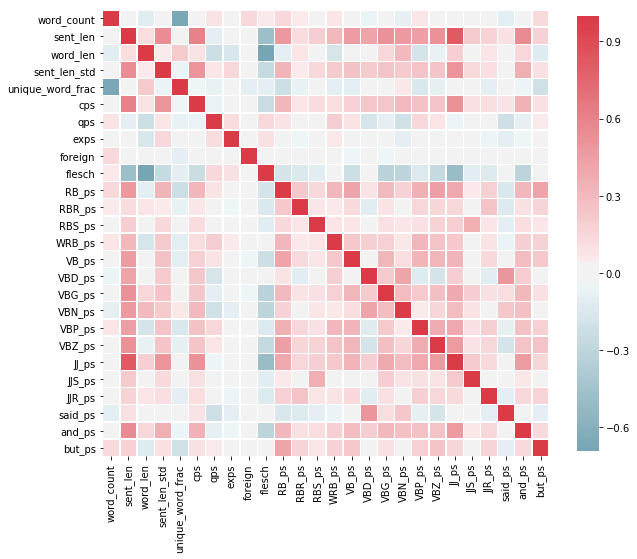

In [38]:
feat_list = ['word_count', 'sent_len', 'word_len', 'sent_len_std', 'unique_word_frac', 
             'cps', 'qps', 'exps', 'foreign', 'flesch',  
             'RB_ps', 'RBR_ps', 'RBS_ps', 'WRB_ps', 'VB_ps', 
             'VBD_ps', 'VBG_ps', 'VBN_ps', 'VBP_ps', 'VBZ_ps', 'JJ_ps', 'JJS_ps', 'JJR_ps',
             'said_ps', 'and_ps', 'but_ps']

#full_feature_df = pd.concat(df_list)



import matplotlib.ticker as ticker
corr = full_feature_df[feat_list].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(10,10))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,cmap=cmap, center=0,
            square=True, linewidths=.3, cbar_kws={"shrink": .8})




full_feature_df[feat_list].head()

min_word_count = 0

feature_array = full_feature_df.loc[(full_feature_df['word_count'] > min_word_count)][feat_list].values
label_array =   full_feature_df.loc[(full_feature_df['word_count'] > min_word_count)]['label'].values
print(full_feature_df[feat_list][(full_feature_df >= 0).all(1)].head())

In [39]:
#combine features
#X = [[i, j, k, l, m, n, o] for i, j, k, l, m, n, o in zip(
#    sent_len_std, unique_word_frac, word_len, cps, qps, exps, flesch)]#, sup_adv_ps, verb_ps, sent_compound)]
#feature_names = ['sentence variability', 'unique word fraction', 
#                 'mean word length', 'commas per sentence', 'questions per sentence', 
#                 'exclamations per sentence', 'flesch']#, 'adverbs per sentence', 
                 #'verbs per sentence', 'sent_compound']



X = feature_array
feature_names = feat_list
Y = label_array

n_samples = len(X)
data_boundaries = [len(i.word_count) for i in [nyt_feature_df, breit_feature_df, wapo_feature_df, guard_feature_df]]
#data_boundaries = [n_articles for i in [nyt, breit, wapo, guard]]
print(data_boundaries)
cumulative_bounds = [0]
for ci, i in enumerate(data_boundaries):
    cumulative_bounds.append(i+cumulative_bounds[ci])
print(cumulative_bounds)
#cumulative_bounds = [0]
#cumulative_bounds = [cumulative_bounds[i-1] + i for i in data_boundaries]
print(len(X))
#X = np.asarray(wc).reshape(-1,1)

#labels
#Y = [0 for i in range(len(nyt_feature_df.word_count))] + \
#    [1 for i in range(len(breit_feature_df.word_count))] + \
#    [2 for i in range(len(wapo_feature_df.word_count))] + \
#    [3 for i in range(len(guard_feature_df.word_count))]
#Y = [0 for i in range(n_articles)] + [1 for i in range(n_articles)] + [2 for i in range(n_articles)] + [3 for i in range(n_articles)]
print(len(Y))


NameError: name 'nyt_feature_df' is not defined

In [ ]:
#test train split
from sklearn.model_selection import train_test_split

indices = np.arange(n_samples)

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, Y, indices, test_size=0.1)
print(idx_train)
print(idx_test)

text_list = nyt_sent + breit_sent + wapo_sent +guard_sent
print(len(text_list))

In [ ]:
from sklearn.linear_model import LogisticRegression
import time

solver = 'saga'

models = {'ovr': {'name': 'One versus Rest', 'iters': [1, 3, 7, 20, 40, 80, 400]},
          'multinomial': {'name': 'Multinomial', 'iters': [1, 5, 21, 80, 200, 400]}}

t0 = time.clock()
n_classes = 4
for model in models:
    # Add initial chance-level values for plotting purpose
    accuracies = [1 / n_classes]
    times = [0]
    densities = [1]

    model_params = models[model]

    # Small number of epochs for fast runtime
    for this_max_iter in model_params['iters']:
        print('[model=%s, solver=%s] Number of epochs: %s' %
              (model_params['name'], solver, this_max_iter))
        lr = LogisticRegression(solver=solver,
                                multi_class=model,
                                C=0.5,
                                penalty='l1',
                                fit_intercept=True,
                                max_iter=this_max_iter,
                                random_state=42,
                                )
        t1 = time.clock()
        lr.fit(X_train, y_train)
        train_time = time.clock() - t1

        y_pred = lr.predict(X_test)
        accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
        density = np.mean(lr.coef_ != 0, axis=1) * 100
        accuracies.append(accuracy)
        densities.append(density)
        times.append(train_time)
    models[model]['times'] = times
    models[model]['densities'] = densities
    models[model]['accuracies'] = accuracies
    print('Test accuracy for model %s: %.4f' % (model, accuracies[-1]))
    print('%% non-zero coefficients for model %s, '
          'per class:\n %s' % (model, densities[-1]))
    print('Run time (%i epochs) for model %s:'
          '%.2f' % (model_params['iters'][-1], model, times[-1]))

fig = plt.figure()
ax = fig.add_subplot(111)

for model in models:
    name = models[model]['name']
    times = models[model]['times']
    accuracies = models[model]['accuracies']
    ax.plot(times, accuracies, marker='o',
            label='Model: %s' % name)
    ax.set_xlabel('Train time (s)')
    ax.set_ylabel('Test accuracy')
ax.legend()
fig.suptitle('Multinomial vs One-vs-Rest Logistic L1\n'
             'Dataset %s' % '20newsgroups')
fig.tight_layout()
fig.subplots_adjust(top=0.85)
run_time = time.clock() - t0
print('Example run in %.3f s' % run_time)
plt.show()


In [ ]:
#from sklearn.model_selection import GridSearchCV
#parameters = {'max_depth':range(3,20)}
#clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
#clf.fit(X=X_train, y=y_train)
#tree_model = clf.best_estimator_
#print (clf.best_score_, clf.best_params_) 


#clf = tree.DecisionTreeClassifier(max_depth = 5)
#clf = clf.fit(X_train, y_train)

from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=20)
for i in range(100,4500, 400):
    rand_start = random.randint(0,4500 - i)
    rf_clf = rf_clf.fit(X_train[rand_start:rand_start + i], y_train[rand_start:rand_start + i])

    print(rf_clf.score(X_test, y_test))
rf_clf = rf_clf.fit(X_train, y_train)
print(rf_clf.score(X_test, y_test))

y_pred = rf_clf.predict(X_test)
#chance = [0 if random.random() > 0.5 else 1 for _ in range(len(y_pred))]

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

xg_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.25,
                                 max_depth=5, random_state=0).fit(X_train, y_train)
print(xg_clf.score(X_test, y_test))

y_pred = xg_clf.predict(X_test)


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
class_names = ['New York Times', 'Breitbart', 'Washington Post', 'Guardian']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha = 'right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix', normalize = True)


In [ ]:
importances = xg_clf.feature_importances_
#std = np.std([tree.feature_importances_ for tree in xg_clf.estimators_],
#             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(X[0])):#.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(X[0])), importances[indices],
       color="r", align='center')#, yerr=std[indices], align="center")
print(indices)
plt.xticks(range(len(X[0])), [feature_names[i] for i in indices], rotation = 45, ha = 'right')
plt.xlim([-1, len(X[0])])
plt.show()


In [ ]:
conf_mat = np.zeros((4,4))
count = 0
for pred, true in zip(y_pred, y_test):
    if pred == 0 and true == 3:
            print(pred, true, count, 'mismatch')
            print(' '.join(text_list[idx_test[count]]))
            input()
    conf_mat[pred,true] += 1.
    count += 1
print(count)
#conf_mat[2,1] += 1000
#[y,x] format (first index (predicted) is on the vertical, second index (truth) is on the horizontal)
plt.imshow(conf_mat)
plt.colorbar()
print(conf_mat, np.sum(conf_mat))
print(Counter(y_test))

# adventures in clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


#pca = PCA(n_components=2).fit(X)
#print(pca)
y_pred = KMeans(init='k-means++', n_clusters=4, n_init = 10, max_iter = 1000).fit_predict(X)


print(Counter(y_pred))


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
class_names = ['New York Times', 'Breitbart', 'Washington Post', 'Guardian']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha = 'right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix', normalize = True)


# Section for testing new article against mean features

In [ ]:
def compare_article(text_features):
    #pub_list = [nyt, breit, wapo]
    wc_mean = [np.mean(i.word_count) for i in pub_list]
    print(wc_mean)
    #wc_mean1 = [np.mean(nyt_wc), np.mean(breit_wc), np.mean(wapo_wc)]
    #print(wc_mean, wc_mean1)
    sent_len_mean = [np.mean(i.sent_len) for i in pub_list]#, np.mean(breit_sent_len), np.mean(wapo_sent_len)]
    sent_len_std_mean = [np.mean(i.sent_len_std) for i in pub_list]#, np.mean(breit_sent_len_std), np.mean(wapo_sent_len_std)]
    unique_word_frac_mean = [np.mean(i.unique_word_frac) for i in pub_list]#, np.mean(breit_unique_word_frac), np.mean(wapo_unique_word_frac)]
    word_len_mean = [np.mean(i.word_len) for i in pub_list]#, np.mean(breit_word_len), np.mean(wapo_word_len)]
    cps_mean = [np.mean(i.cps) for i in pub_list]#, np.mean(breit_cps), np.mean(wapo_cps)]
    features = ['sentence length', 'sentence length distribution', 'unique word fraction', 'word length', 'commas per sentence']
    mean_features = [[i, j, k, l, m] for i, j, k, l, m in zip(sent_len_mean, sent_len_std_mean, unique_word_frac_mean, word_len_mean, cps_mean)]
    print(mean_features)
    pickle.dump(mean_features, open('mean_features.p', 'wb'))
    return [[float(i/j) for i,j in zip(text_features, pub_features)] for pub_features in mean_features]

In [ ]:
#generate features for a single text (THIS NEEDS TO GO INTO THE CLASS)
def generate_features(text):
    sent_tok, word_tok, string_counts = prepare_text(text)
    sent_tok = sent_tok[0]
    word_tok = word_tok[0]
    string_counts = string_counts[0]
    
    punctuation_set = set(string.punctuation)
    word_count = len([word for word in word_tok if word not in punctuation_set])
    sent_count = len(sent_tok)
    sent_len = float(word_count / sent_count)
    sent_std = np.std([len(sent) for sent in sent_tok])

    unique_word_count = len(set([word for word in word_tok if word not in punctuation_set]))
    unique_word_frac = float(unique_word_count / word_count)
    mean_word_length = np.mean([len(word) for word in word_tok if word not in punctuation_set])

    cps = string_counts[',']/sent_count
    return [sent_len, sent_std, unique_word_frac, mean_word_length, cps]

In [ ]:
#print(' '.join(nyt_sent[0]))
features = generate_features([' '.join(nyt_sent[10])])

print(features)
features_compare_to_mean = compare_article(features)
features = ['sentence length', 'sentence length distribution', 'unique word fraction', 'word length', 'commas per sentence']
plt.title('Features compared to average for {}'.format("New York Times"))
plt.bar(list(range(5)), features_compare_to_mean[2], color = 'r')
plt.bar(list(range(5)), [1 for _ in range(5)], color = 'black', alpha = 0.5)
#plt.ylim((0,1.2))
plt.xticks(range(5), features, rotation = 45, ha = 'right')
#plt.bar(list(range(5)), features_compare_to_mean[1], alpha = 0.5)

#plt.bar(list(range(5)), features_compare_to_mean[2], alpha = 0.5)

In [ ]:
from sklearn.externals import joblib
joblib.dump(clf, 'decision_tree_10.pkl') 

In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())